# (1): Image Manipulation

This project hinges on our ability to model and remove the bright emission from the circumstellar disk, to have a better chance at finding a faint CPD component hidden in its glare.  Such a model of that emission is itself of great interest to the community, since it will help facilitate comparisons between how this emission varies spatially among different populations of disks.

To develop some intuition about *what* you will be modeling, and *how* you will be doing that, it is important to become familiar with mm/radio images of disks and their general manipulation.  This part of the project should help you learn how to load .FITS data, extract their information, and plot, manipulate, and annotate the images.  This notebook will get you started, and leaves blank cells for you to develop code to achieve various goals.

**(A): Load a .FITS file:**

We will start the project with the disk around the young star GW Lup.  You can download the $\lambda = 1.3$ mm wavelength continuum image from the DSHARP data repository, and then load the image (a 2-D array) and the header (a dictionary of information about the image) with some standard Astropy tools.

In [57]:
import os, sys, time           # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
from matplotlib.patches import Ellipse
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)    # image visualization packages
%matplotlib inline                

# disk target name
disk_name = 'GWLup'

# set this to your project directory (or however you like)
working_dir = '/Users/sandrews/Desktop/DSHARP_CPDs/'

# if you don't already have the datafile, download it
if not os.path.exists(working_dir+disk_name+'_continuum.fits'):
    dsharp_url = 'https://bulk.cv.nrao.edu/almadata/lp/DSHARP/images/'+disk_name+'_continuum.fits'
    print('Downloading .FITS image...')
    urllib.request.urlretrieve(dsharp_url, working_dir+disk_name+'_continuum.fits')
    print('...Download complete.')

# load the .FITS file into a 2-D array (image) and header dictionary (header)
data = fits.open(disk_name+'_continuum.fits')
image = np.squeeze(data[0].data)
header = data[0].header
print(header)    # this shows you what is in the header

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    4                                                  NAXIS1  =                 3000                                                  NAXIS2  =                 3000                                                  NAXIS3  =                    1                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   1.236248761415E-05                                                  BMIN    =   1.187190413475E-05                                                  BPA     =   5.454711914062E-01          

**(B) Explore the Data Contents:**

Now we can extract some basic information content about the image, primarily from the header dictionary.  First, we want to reconstruct the image coordinate frame, by calculating the RA and DEC of each pixel in the image.  Next, we extract the observing frequency of the image.  And then, we extract the parameters of the "beam", or point-spread function (PSF).  For mm/radio images, the PSF is an elliptical Gaussian: the header records the full-width at half-maximum (FWHM) along the major and minor axes of that ellipse, as well as the position angle (measured toward the east, starting at north) of the major axis.    

In [58]:
# number of pixels in RA, DEC dimensions
nx, ny = header['NAXIS1'], header['NAXIS2']
print(nx, ny, image.shape)    # can see that these are the same as the array dimensions

# coordinate frames can be reconstructed from a mapping to pixels with header variables
# these 1-D mappings are in **degrees** units
RA = header['CRVAL1'] + header['CDELT1'] * (np.arange(nx) - (header['CRPIX1'] - 1))
DEC = header['CRVAL2'] + header['CDELT2'] * (np.arange(ny) - (header['CRPIX2'] - 1))

# convert these to offsets from the image center, in **arcseconds** units
RAo, DECo = 3600 * (RA - header['CRVAL1']), 3600 * (DEC - header['CRVAL2'])

# shift these coordinates to account for the center of the disk (offRA, offDEC)
offRA, offDEC = 0., 0.    # we can experiment with these
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC

# now convert these to two-dimensional arrays of RA and DEC offsets from the disk center for each pixel
dRA, dDEC = np.meshgrid(RAo_shift, DECo_shift)


# get the observing frequency (in Hz units)
freq = header['CRVAL3']


# get the beam parameters (in **arcseconds** for the FWHM, and **degrees** for the position angle)
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']

# compute the beam area (in **steradians**)
# trust me...this is tricky, but the first part is the integral of the 2-D gaussian PSF
beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

3000 3000 (3000, 3000)


**(C) Image Visualization:**

Here we will make a basic plot of the image and some standard annotations, to introduce the formatting.  

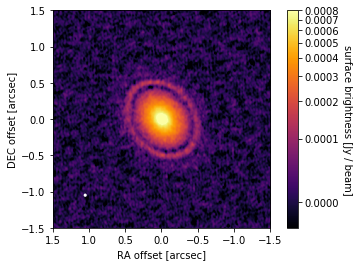

In [71]:
# define the full image boundaries with a list of the min/max RA and DEC offsets
# (note the reverse ordering for RA, since this is plotted with E to the left)
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())

# now set the RA and DEC offset ranges you want to show
dRA_lims  = [1.5, -1.5]      # (same reverse ordering to ensure E is to the left)
dDEC_lims = [-1.5, 1.5]

# now define the color-map, intensity limits, and stretch
cmap = 'inferno'
vmin, vmax = -3e-5, 8e-4    # these are in Jy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [Jy / beam]', rotation=270, labelpad=13)

# make an ellipse to show the PSF (beam) dimensions, in the lower left corner (its very small!)
beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

**Activities:**

So, once you have experimented with the code above, there are some useful things to try on your own.  

- Remake the image figure above, but this time in "brightness temperatures" (Kelvin units) instead of surface brightnesses (Jy/beam).  The brightness temperature ($T_b$) is just a different way to cast a surface brightness ($I_\nu$).  It is defined such that $I_\nu = B_\nu(T_b)$, where $B_\nu$ denotes the Planck function, which has units of erg / s / cm^2 / Hz / steradian.  Typically, in radio astronomy we use the Rayleigh-Jeans approximation to write $B_\nu \approx 2 \nu^2 k_B T_b / c^2$.  The only real "trick" here is that you have to convert $I_\nu$ from its weird units (Jy / beam means Jansky's per beam area).  The $T_b$ image should provide much more legible units for the scalebar (i.e., something like 0 to 20 K would be fine).     

- Code up the equation of an ellipse to plot on top of the image (you can use the Ellipse function I employed to make the beam to check your work, but do the actual math: it will be useful in the next steps).  The ellipse parameters should be the semimajor axis $a$, the inclination angle $i$ (where $\cos{i} = b/a$, with $b$ the semiminor axis), and the position angle of the major axis (think a simple code of the operation of a "rotation matrix").  Try and set it up so the ellipse is aligned with the emission gap.  

In [73]:
# your code here

**(D) Deprojection into Polar Coordinates:**

tbd